# AirBnB Data

In this problem, we will predict the price of an AirBnB listing as a function of its attributes. We get our data from this source: https://www.kaggle.com/c/airbnblala/data#

We first import all of the modules we need.

In [346]:
# reminder: you can install packages (eg, statsmodels) with 
!pip install statsmodels

In [347]:
import numpy as np
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt 
%matplotlib inline

import random as rand

Then we load the data. We will also print a list of each columns together with its datatype, using the "type" function.

In [348]:
np.random.seed(26)
df = pd.read_csv('airbnb.csv')

feature_names = df.columns
for i in range(96):
    print(str(i), "\t", str(feature_names[i]),"\t\t\t", str(type(df.iloc[0,i])))

0 	 id 			 <class 'numpy.int64'>
1 	 listing_url 			 <class 'str'>
2 	 scrape_id 			 <class 'numpy.int64'>
3 	 last_scraped 			 <class 'str'>
4 	 name 			 <class 'str'>
5 	 summary 			 <class 'str'>
6 	 space 			 <class 'float'>
7 	 description 			 <class 'str'>
8 	 experiences_offered 			 <class 'str'>
9 	 neighborhood_overview 			 <class 'str'>
10 	 notes 			 <class 'float'>
11 	 transit 			 <class 'str'>
12 	 access 			 <class 'str'>
13 	 interaction 			 <class 'str'>
14 	 house_rules 			 <class 'float'>
15 	 thumbnail_url 			 <class 'numpy.float64'>
16 	 medium_url 			 <class 'numpy.float64'>
17 	 picture_url 			 <class 'str'>
18 	 xl_picture_url 			 <class 'numpy.float64'>
19 	 host_id 			 <class 'numpy.int64'>
20 	 host_url 			 <class 'str'>
21 	 host_name 			 <class 'str'>
22 	 host_since 			 <class 'str'>
23 	 host_location 			 <class 'str'>
24 	 host_about 			 <class 'str'>
25 	 host_response_time 			 <class 'float'>
26 	 host_response_rate 			 <class 'float'>
27 	 host_accept

## a) Train / Test Split

The price columns, 61, 62, and 63, are our labels; the rest of the columns are our features. We now will generate a data matrix ($X$ from class), use column 61 as a target vector ($y$ from class), and create a train/test split so that we can empirically test for overfitting.

To make the 80 / 20 train test split, we shuffle the data and select the first $80\%$ as the train data, with $20\%$ held out for validation.

Use the code below to create a train / test split.

In [349]:
df = df[~df['price'].isna()] # let's only consider the examples for which the price is known
df = df.sample(frac = 1) # we shuffle the data so that our train/test split will be truly random

train_proportion = 0.8
n = len(df)
print('Size of dataset: ', str(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
t = int(train_proportion * n)

target = df['price']
price_columns = ['price','weekly_price','monthly_price']
data = df.loc[:, ~df.columns.isin(price_columns)]

# the following variable records the features of examples in the training set
train_x = data.iloc[0: t]
# the following variable records the features of examples in the test set
test_x = data.iloc[t :]
# the following variable records the labels of examples in the training set
train_y = target[0: t]
# the following variable records the labels of examples in the test set
test_y = target[t:]

# let's take a look
print('Training dataset: ', train_x)

Size of dataset:  25951
Training dataset:               id                            listing_url       scrape_id  \
7594   14105094  https://www.airbnb.com/rooms/14105094  20180303203649   
21726  13550201  https://www.airbnb.com/rooms/13550201  20180303203649   
17786  12284280  https://www.airbnb.com/rooms/12284280  20180303203649   
11689  16220723  https://www.airbnb.com/rooms/16220723  20180303203649   
15453   8191897   https://www.airbnb.com/rooms/8191897  20180303203649   
...         ...                                    ...             ...   
14067  22341125  https://www.airbnb.com/rooms/22341125  20180303203649   
4501   13099377  https://www.airbnb.com/rooms/13099377  20180303203649   
19453   2447138   https://www.airbnb.com/rooms/2447138  20180303203649   
13354  19532525  https://www.airbnb.com/rooms/19532525  20180303203649   
15873   8053664   https://www.airbnb.com/rooms/8053664  20180303203649   

      last_scraped                                               nam

## b) Real-Valued Data

Your first task will be to fit a linear model to the simplest type of data available - the real-valued parameters. Once you fit your model to the train data, you will need to print train and test mean squared error, as well as plot the predicted vs the real price.

The starter code includes some data processing routines, as well as a plot function.

Now, let's select out all numerical data that might be useful for predicting the price. Here is a list:

  - host_listings_count
  - host_total_listings_count
  - accomodates
  - bathrooms
  - bedrooms
  - guests_included		
  - extra_people
  - minimum_nights
  - maximum_nights
  - availability_30
  - availability_60
  - availability_90
  - availability_365
  - number_of_reviews
  - review_scores_rating
  - review_scores_accuracy
  - review_scores_cleanliness
  - review_scores_checkin
  - review_scores_communication
  - review_scores_location
  - review_scores_value

These will be easy to grab, but it's important to also include the following stored as a string:

  - beds
  - security_deposit
  - cleaning_fee
  
For those, we provide write a utility function, which interprets any non-numerical value as a "0", which is an accurate interpretation of "N\A" in this context.

In [350]:
# "This function converts strings to floating point values 
# and strings that cannot be represented as a number (like NA) are converted to zeros"
def string_to_float(string):
    try:
        return float(string)
    except:
        return 0.0

labels_real = [
  'host_listings_count',
  'host_total_listings_count',
  'accommodates',
  'bathrooms',
  'bedrooms',
  'guests_included',
  'extra_people',
  'minimum_nights',
  'maximum_nights',
  'availability_30',
  'availability_60',
  'availability_90',
  'availability_365',
  'number_of_reviews',
  'review_scores_rating',
  'review_scores_accuracy',
  'review_scores_cleanliness',
  'review_scores_checkin',
  'review_scores_communication',
  'review_scores_location',
  'review_scores_value'
]


labels_string = [
    'beds',
    'security_deposit',
    'cleaning_fee'
]

Extract the real valued data first and cast it as an numpy array with np.asarray()

In [351]:
# the following variable should have as many columns as real variables, and as many rows as examples in the training set    
train_vals_real = np.asarray(train_x[labels_real])
# the following variable should have as many columns as real variables, and as many rows as examples in the test set
test_vals_real = np.asarray(test_x[labels_real])



Now, we can extract the specific columns related to these labels, convert them to floats as necessary, but **DO NOT** convert the result to numpy arrays yet. (We will run an asseration test to make sure everything is working as intended.)

Use .fillna() and .applymap() methods to apply the string_to_float() function elementwise. In particular, impute NaN values with 0.0 (float valued data). You shouldn't need more than one line per expression below.

In [352]:
# the following variable should have as many columns as string variables, and as many rows as examples in the training set  
train_vals_from_string = train_x[labels_string].fillna(0).applymap(string_to_float)
# the following variable should have as many columns as string variables, and as many rows as examples in the test set      
test_vals_from_string = test_x[labels_string].fillna(0).applymap(string_to_float)

In [353]:
assert(train_vals_from_string.applymap(lambda x:type(x)!=str).all(skipna=False).all(skipna=False) == True)
assert(test_vals_from_string.applymap(lambda x:type(x)!=str).all(skipna=False).all(skipna=False) == True)

Now we cast them as np arrays

In [354]:
train_vals_from_string = np.asarray(train_vals_from_string)
test_vals_from_string = np.asarray(test_vals_from_string)

To get to a usable matrix of data, we must concatenate these using "np.concatenate()" which concatenates np.array objects together with an appropriately chosen axis. **Don't forget to include the offset term!** You may need to use .reshape() to cast the offset term into an array of the appropriate dimensions.

In [355]:
train_vals = np.concatenate((train_vals_real, 
                             train_vals_from_string, 
                             np.ones(t).reshape(t, 1)), axis=1)
test_vals = np.concatenate((test_vals_real, 
                            test_vals_from_string, 
                            np.ones(n - t).reshape(n - t, 1)), axis=1)

Now let's fit the linear model, compute and print the MSE, and plot the predicted versus the real data.

We provide some useful helper functions below, though we ask you to complete the MSE function.

Plotting all the test data might significantly slow down this notebook; if that happens, feel free to plot just the first couple hundred points.

In [356]:
# This function just computes the mean squared error
def MSE(y, pred):
    return np.square(np.subtract(y,pred)).mean()

# This function plots the main diagonal;for a "predicted vs true" plot with perfect predictions, all data lies on this line
def plotDiagonal(xmin, xmax):
    xsamples = np.arange(xmin,xmax,step=0.01)
    plt.plot(xsamples,xsamples,c='black')

# This helper function plots x vs y and labels the axes
def plotdata(x=None,y=None,xname=None,yname=None,margin=0.05,plotDiag=True,zeromin=False):
    plt.scatter(x,y,label='data')
    plt.xlabel(xname)
    plt.ylabel(yname)
    range_x = max(x) - min(x)
    range_y = max(y) - min(y)
    if plotDiag:
        plotDiagonal(min(x)-margin*range_x,max(x)+margin*range_x)
    if zeromin:
        plt.xlim(0.0,max(x)+margin*range_x)
        plt.ylim(0.0,max(y)+margin*range_y)
    else:
        plt.xlim(min(x)-margin*range_x,max(x)+margin*range_x)
        plt.ylim(min(y)-margin*range_y,max(y)+margin*range_y)
    plt.show()

# This function plots the predicted labels vs the actual labels (We only plot the first 1000 points to avoid slow plots)
def plot_pred_true(test_pred=None, test_y=None, max_points = 1000):
    plotdata(test_pred[1:max_points], test_y[1:max_points],'Predicted', 'True', zeromin=True)

In [357]:
# This function runs OLS and bypasses any SVD (Singular Value Decomposition) convergence errors by refitting the model
def run_OLS(train_y, test_y, train_vals, test_vals):
    ols_model = sm.regression.linear_model.OLS(train_y, train_vals)
    while True: # Bypasses SVD convergence assertion error
        try:
            results = ols_model.fit()
            break
        except:
            None
            
    w = np.array(results.params).reshape([len(results.params),1])

    train_pred = np.matmul(train_vals,w)
    test_pred = np.matmul(test_vals,w)

    train_MSE = MSE(train_y, train_pred.flatten())
    test_MSE = MSE(test_y, test_pred.flatten())
    
    return train_MSE, test_MSE, test_pred

In [358]:
train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_vals, test_vals)

Train MSE	 5641.824370720242
Test MSE	 5716.17435599449


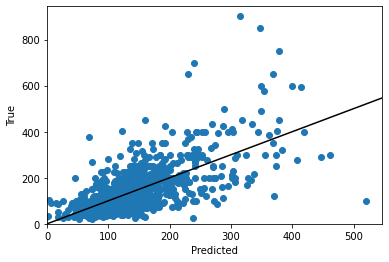

In [359]:
print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y) #.flatten() will make sure the dimensions match

The two seem to trend in the same direction, but there is still plenty of room for improvement.

We are missing some of the most important data, namely, the type of rental. After all, a well-reviewed tent will never cost as much as a poorly-reviewed house. We'll ignore the issue of location for now, because it is significantly thornier.

Unfortunately, this data is stored in categorical columns, which require a little more work to utilize. Here are the data parameters:

  - property_type
  - room_type
  - bed_type
  - cancellation_policy
  - host_response_time
  
These are all best handled with boolean encoding. It's worth mentioning that there is an additional category which can be handled with one-hot vectors, where more than one entry in the column can be $1$:

  - host_verifications

There are also many boolean parameters, which might inform the price:

  - require_guest_profile_picture
  - require_guest_phone_verification
  - instant_bookable
  - is_business_travel_ready
  - has_availability
  - is_location_exact
  - host_identity_verified
  - host_has_profile_pic
  - host_is_superhost

Let's handle the boolean values first.

## c) Boolean Data

We've provided a helper function to convert the values stored in the original dataset - "t" and "f" - into Python "true" and "false." Extract the arrays for these parameters, then concatenate this new data with all the data you had previously.

In [360]:
# Converts from "t" and "f" into true and false
def string_to_bool(string):
    return string == 't'

bool_labels = [
  'require_guest_profile_picture',
  'require_guest_phone_verification',
  'instant_bookable',
  'is_business_travel_ready',
  'has_availability',
  'is_location_exact',
  'host_identity_verified',
  'host_has_profile_pic',
  'host_is_superhost'
]

In [361]:
# the following variable should have as many columns as real variables, and as many rows as examples in the training set   
train_bv = train_x[bool_labels].applymap(string_to_bool)
# the following variable should have as many columns as real variables, and as many rows as examples in the test set
test_bv = test_x[bool_labels].applymap(string_to_bool)

In [362]:
assert(train_bv.applymap(lambda x:type(x)== bool).all(skipna=False).all(skipna=False) == True)
assert(test_bv.applymap(lambda x:type(x)== bool).all(skipna=False).all(skipna=False) == True)

In [363]:
train_bv = np.asarray(train_bv)
test_bv = np.asarray(test_bv)

In [364]:
# concatenate the real and boolean features to form your X train and test matrices
train_vals = np.concatenate((train_vals_real, 
                             train_bv, 
                             np.ones(t).reshape(t, 1)), axis=1)

test_vals = np.concatenate((test_vals_real, 
                            test_bv, 
                            np.ones(n - t).reshape(n - t, 1)), axis=1)

Now, refit, and compute the MSE.

In [365]:
train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_vals, test_vals)

Train MSE	 6303.3339315570975
Test MSE	 6519.273805927246


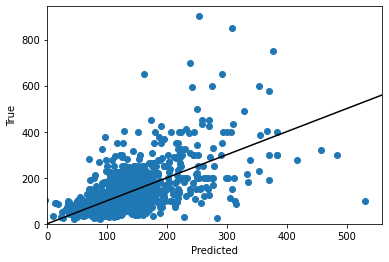

In [366]:
print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

That didn't help much! In fact, that's not terribly surprising. See what the MSE is if we use only the boolean values:

In [367]:
train_bools = np.concatenate((train_bv, np.ones(t).reshape(t, 1)), axis=1)

test_bools = np.concatenate((test_bv, np.ones(n - t).reshape(n - t, 1)), axis=1)

Train MSE	 10392.964876310676
Test MSE	 10338.938387812601


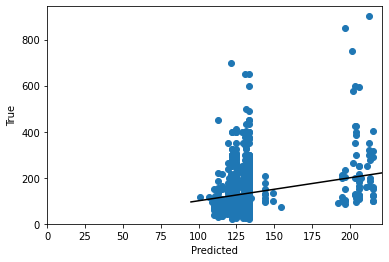

In [368]:
train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_bools, test_bools)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

In fact this is not too surprising - the most informative data is going to be categorical, since a well-reviewed tent is never going to cost as much as a poorly reviewed full house.

## d) Categorical Data

Transform the data into one-hot vectors. The categories are easy to extract using the "np.unique()" function.

Here, we ask that you contribute a little more to the helper function, since this transformation is not trivial. Notice that the categories are passed as an argument - this is important, in case the test set doesn't have a representation for all of the categories in the training set.

Make sure your function is linear in the number of data points (entries in the column) which it processes. You can use the nested loop structure provided, or clever list comprehensions. Bonus points if you use a "Dataframe" object in a clever way that makes the function significantly faster.

If a category appears in the test set but not in the training set, the "one hot" vector should be a vector of zeros for that parameter. (In other words, we one-hot encode only the categories in the training set)

In [369]:
cat_labels = [
  'property_type',
  'room_type',
  'bed_type',
  'cancellation_policy',
  'host_response_time'
]

#Sets of all categories in a particular column
cats_sets = [train_x.loc[:, label].fillna('NaN').unique() for label in cat_labels]
cats_sets

[array(['Apartment', 'Loft', 'Guest suite', 'Bed and breakfast',
        'Townhouse', 'Condominium', 'Other', 'House', 'Serviced apartment',
        'Hostel', 'Bungalow', 'Boutique hotel', 'Guesthouse', 'Timeshare',
        'Vacation home', 'Villa', 'Dorm', 'Boat', 'Aparthotel', 'In-law',
        'Hotel', 'Resort', 'Yurt', 'Earth house', 'Camper/RV', 'Cabin',
        'Treehouse', 'Island', 'Casa particular (Cuba)', 'Tent'],
       dtype=object),
 array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object),
 array(['Real Bed', 'Airbed', 'Couch', 'Futon', 'Pull-out Sofa'],
       dtype=object),
 array(['moderate', 'strict', 'flexible', 'super_strict_30',
        'super_strict_60'], dtype=object),
 array(['NaN', 'within an hour', 'within a few hours',
        'a few days or more', 'within a day'], dtype=object)]

In [370]:
# Computes a onehot vector for every entry in column given a set of categories 'cats'
# Here, 'col' should be the set of unique categories for the input 'column': you can fetch this from 'cats_sets'

def onehot(column=None, col=None):
    size = column.size
    matrix = np.concatenate([np.array(column == c).reshape(size, 1) for c in col], axis = 1)
    return matrix

In [371]:
# These may take more than one line of code, since you will need to concatenate several numpy arrays
# train_cat_vals = pd.concat(onehot(train_x, cat_labels[cat_label] for cat_label in cat_labels), axis = 1)
# test_cat_vals = np.concatenate(onehot(test_x[cat_label], cats_sets) for cat_label in cat_labels)

train_cat_vals = np.concatenate([onehot(train_x[cat_labels[idx]], cats_sets[idx]) for idx in range(len(cat_labels))], axis = 1)
test_cat_vals = np.concatenate([onehot(test_x[cat_labels[idx]], cats_sets[idx]) for idx in range(len(cat_labels))], axis = 1)

Concatenate the one-hot encoded features with all the data you had previously.

In [372]:
train_vals = np.concatenate((train_vals_real, 
                             train_vals_from_string,
                             train_bv, 
                             train_cat_vals,
                             np.ones(t).reshape(t, 1)), axis=1)
test_vals =np.concatenate((test_vals_real, 
                           test_vals_from_string,
                           test_bv, 
                           test_cat_vals,np.ones(n - t).reshape(n -t, 1)), axis=1)

In [373]:
train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_vals, test_vals)

Train MSE	 4958.2048243645095
Test MSE	 5154.586689258608


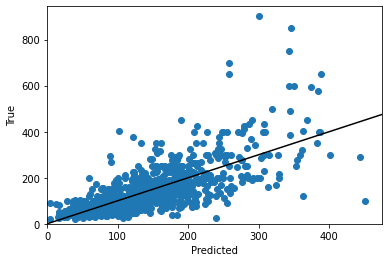

In [374]:
print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

We're making significant improvements! About $10 \%$ of the previous MSE can be accounted for with this set of parameters.

## e) Set data

There is another type of data - stored in the host_verifications column - that we haven't used yet. This is set data, best encoded with a many-hot vector.

This particular column does not turn out to be particularly informative, but it is valuable to work with it firsthand.

The set data happens to be stored in a format that is very close to a valid declaration of a Python string array, so all we have to do is a little parsing:

In [375]:
unparsed_str = train_x.loc[:, 'host_verifications'][0]
print(unparsed_str)
print(type(unparsed_str))

['email', 'phone', 'facebook', 'google', 'reviews']
<class 'str'>


In [376]:
parsed_str = train_x.loc[:, 'host_verifications'][0].strip('[]').replace('\'','').split(', ')
print(parsed_str)
print(type(parsed_str))
print([type(i) for i in parsed_str])

['email', 'phone', 'facebook', 'google', 'reviews']
<class 'list'>
[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]


Write a helper function (using the previos two code blocks as reference) that will parse the strings found in the host_verifications column into appropriate string arrays.

In [377]:
def parse_str(string):
    arr = np.array(string.strip('[]').replace('\'','').split(', '))
    return arr

Now apply this function elementwise to the column host_verifications; note that a column of dataframe is a Series object; and Series object use the method .apply as opposed to .applymap.

In [378]:
train_set_vals = train_x['host_verifications'].apply(parse_str)
test_set_vals = test_x['host_verifications'].apply(parse_str)

print(train_set_vals[0])
print(type(train_set_vals[0]))

['email' 'phone' 'facebook' 'google' 'reviews']
<class 'numpy.ndarray'>


By the way, if you are working on your project, there is a decent chance that sets were stored in a format similar to what we saw here. Using similar string compositions, you will likely be able to similarly parse the data into Python container types (whether arrays or proper Python sets).

Now, take this array of arrays, and turn it into a many-hot vector. You are welcome to use the nested loop structure below, or array comprehensions, or even the DataFrame object if you wish.

In [379]:
# This is the collection of all types we need to worry about.
vtypes = train_set_vals.explode().unique()

def manyhot(column=None, col=None): 
    height = column.size
    width = len(col)
    siz = (height,width)
    matrix = np.zeros(siz)
    arr = np.array(column)
    for i in range(width):
        for j in range(height):
            if col[i] in arr[j]:
                matrix[j][i] = 1
    return matrix

In [380]:
train_set_vals = manyhot(train_set_vals, vtypes)
test_set_vals = manyhot(test_set_vals, vtypes)

We will attach it to the full list of values used so far, but it won't change the MSE much, unfortunately:

In [381]:
train_vals = np.concatenate((train_set_vals, 
                             train_cat_vals, 
                             train_vals_from_string, 
                             train_vals_real, 
                             train_bv, 
                             np.ones(t).reshape((t, 1))), axis = 1)

test_vals = np.concatenate((test_set_vals, 
                            test_cat_vals, 
                            test_vals_from_string, 
                            test_vals_real, 
                            test_bv, 
                            np.ones(n - t).reshape((n - t, 1))), axis = 1)



Train MSE	 4947.910778696334
Test MSE	 5157.829527741999


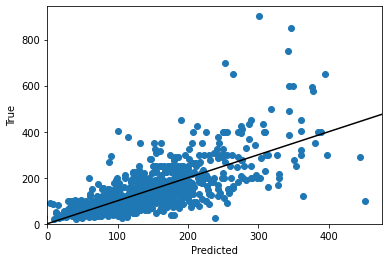

In [382]:
train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_vals, test_vals)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

## f) Location, location, location

If you remember, a common refrain in Real Estate is "location, location, location." We're treating Manhattan properties with the same formula as Staten Island!

The most naive way to include location data would be with the categories "latitude" and "longitude" - after all, these are continuous variables, so why not include them in the simplest manner possible?

Load the longitude and lattitude data in, then try to see what the MSE is if you use *only* these variables,

Train MSE	 9862.557467279337
Test MSE	 9817.759379066658


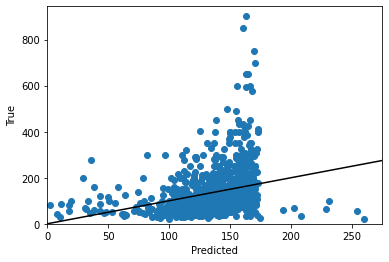

In [383]:
loc_labels = ['latitude',
             'longitude']

train_loc_vals = np.concatenate((train_x[loc_labels], np.ones(t).reshape((t, 1))), axis = 1)
test_loc_vals = np.concatenate((test_x[loc_labels], np.ones(n - t).reshape((n - t, 1))), axis = 1)


train_loc_vals = np.array(train_loc_vals)
test_loc_vals = np.array(test_loc_vals)

train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_loc_vals, test_loc_vals)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

Clearly, this is insufficient. The reality is that price is a highly nonlinear function of location; simply going north or south does not directly translate into rental price.

There are several solutions. We could expand our basis of functions, for instance, to use more than linear functions of longitude and lattitude:

In [384]:
tr_lat = train_loc_vals[:,0]
tr_long = train_loc_vals[:,1]
train_lv2 = np.transpose( np.vstack([tr_lat, tr_long,
                           tr_lat**2, tr_long**2, np.multiply(tr_lat,tr_long)]) )

te_lat = test_loc_vals[:,0]
te_long = test_loc_vals[:,1]
test_lv2 = np.transpose( np.vstack([te_lat, te_long,
                           te_lat**2, te_long**2, np.multiply(te_lat,te_long)]) )

Train MSE	 9393.945052191462
Test MSE	 9393.008084780944


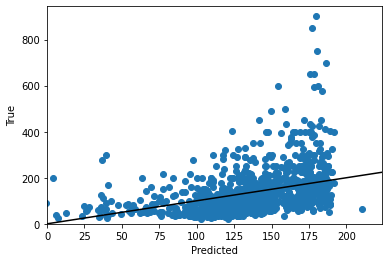

In [385]:
train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_lv2, test_lv2)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

This helps somewhat with a small nonlinear basis, and a lot with a large basis.

There are many different types of nonlinear location basis, of course. We've used a simple polynomial basis above. We might choose a Fourier basis instead; this is especially useful if we believe our data will have strong periodic components, but really this will handle any data in a confined space (assuming our data is sufficiently densely sampled to avoid horrible artefacts).

There is a far simpler basis, however, which will work great in our case. Imagine a function that has value $1$ within a specific, closed region - say, an island, or a zip code. Now imagine we have a large list of such functions, which collectively tile the entire region of interest. Bonus points if the regions do not overlap, though that is technically not even necessary.

Now, these functions are going to have fewer nice mathematical properties than Fourier features, or wavelets, or even polynomials - two adjacent points will tell us nothing about each other if they are on different sides of one of these artificial borders - but these functions might be very easy to compute. Taking a quick look at the list of columns, it seems we have a number of categorical location parameters to choose from.

  - street
  - neighbourhood
  - neighbourhood_cleansed
  - neighbourhood_group_cleansed
  - city
  - state
  - zipcode
  - market
  - smart_location
  - country_code
  - country
  
Use one of the most granular descriptions available - zipcode - and see if that is a good descriptor of location.

In the next cell, build a model using this parameter ONLY and print the train and test MSE.

Note that it may seem cumbersome to put 'zipcode' in a list, but formatting the one-hot encoding as before ensures the methods are able to handle correct data types (e.g. no data type errors arise between Series vs Dataframe)

In [386]:
l = ['zipcode']

cats_sets = [train_x.loc[:,i].fillna('NaN').unique() for i in l]
print("Number of categories\t", len(cats_sets[0]))

train_zip = onehot(train_x[l], cats_sets[0])
test_zip = onehot(test_x[l], cats_sets[0])

Number of categories	 189


Now add an offset feature to 'train_zip' & 'test_zip' to create 'train_zip_only' & 'test_zip_only' and then fit your model. 

Train MSE	 8651.36001839523
Test MSE	 8846.119030828417


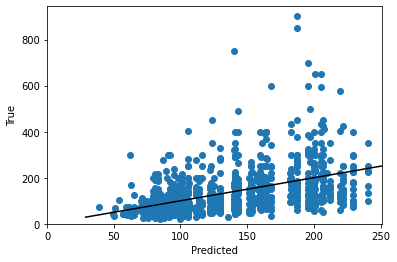

In [387]:
train_zip_only = np.concatenate((train_zip, np.ones(t).reshape(t, 1)), axis = 1)
test_zip_only = np.concatenate((test_zip, np.ones(n-t).reshape(n - t, 1)), axis = 1)

train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_zip_only, test_zip_only)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

It might not look like much, but it's certainly better than raw longitude and lattitude. Compound the zip code data with the features that we've already accumulated, and print out the MSE scores and draw the plots for the full set:

In [388]:
train_vals = np.concatenate((train_zip, 
                             train_set_vals, 
                             train_cat_vals, 
                             train_vals_from_string, 
                             train_vals_real, 
                             train_bv, 
                             np.ones(t).reshape((t, 1))), axis = 1)

test_vals = np.concatenate((test_zip, 
                            test_set_vals, 
                            test_cat_vals, 
                            test_vals_from_string, 
                            test_vals_real, 
                            test_bv, 
                            np.ones(n - t).reshape((n - t, 1))), axis = 1)




Train MSE	 3950.210964162419
Test MSE	 4271.579578574983


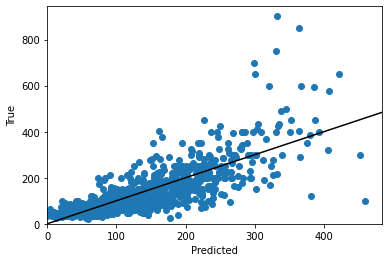

In [389]:
train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_vals, test_vals)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

This is by far the best result so far. It seems that location brought in some new information, giving us significantly more predictive power.

We are close to the end of all standard techniques (maybe some of the features we've modeled as reals should really be ordinals), but there is one more type of data that we haven't utilized yet.

## g) Text

The following columns consist of long-form textual descriptions:

  - name
  - summary
  - space
  - neighborhood_overview
  - notes
  - transit
  - access
  - interaction
  - house_rules

We will experiment with using features from a pretrained neural network to represent this data.
The neural network has learned an internal representation (say, at some hidden layer of the network) that it uses to make its predictions on a different task (such as sentiment prediction for sentences). 

We will use this internal representation directly for our task of AirBnB price prediction.
Using an internal representation from an unrelated model as a feature is a common technique known as transfer learning.

We will use pretrained features from the Universal Sentence Encoder (USE), which was designed explicitly for transfer learning to different tasks. 
[This paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46808.pdf) documents how this neural network architecture was designed and trained: 
This network consumes text of arbitrary length, and produces a feature vector of length $512$. 

Your TAs have precomputed these features for all of the columns above into the table "airbnb-use-embeddings.csv",
available [as a zip file on the course website](https://people.orie.cornell.edu/mru8/orie4741/homework/airbnb-use-embeddings.zip).
The id of each AirBnB listing is provided, along with features with names of the form "column_number:feature_number". That is, the 468th feature of the 5th text data column (also known as the "name" column) will be found at '5:468'.

You can use [this demo code](https://tfhub.dev/google/universal-sentence-encoder/2)) to explore the USE embedding further. If you would like to use this (or any other) embedding for your project, you are welcome to come to Office Hours and we will gladly help you with your project.

Returning to the AirBnB dataset, we can import the data into a new dataframe. Since our training data has been shuffled, we use a dataset join to assemble the data below.

In [390]:
df_tf = pd.read_csv("airbnb-use-embeddings.csv") # Will take a while to read

In [391]:
train_all = train_x.merge(df_tf, on='id',how='left')
test_all = test_x.merge(df_tf, on='id',how='left')

In [392]:
print('Number of original features \t', len(train_x.columns))

train_embed = np.array(train_all.iloc[:, len(train_x.columns):])
test_embed = np.array(test_all.iloc[:, len(train_x.columns):])

Number of original features 	 93


To find out how useful these parameters are (or aren't), fit a linear model of price as a function of embedding only (with offset!). Keep in mind that due to the sheer number of parameters to fit, **this step may take several minutes**.

Train MSE	 4891.554512058394
Test MSE	 8265.085665717574


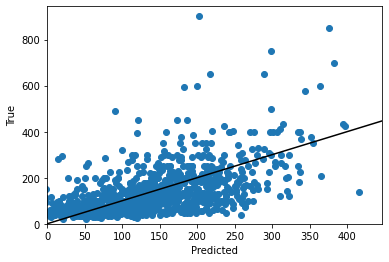

In [393]:
train_embed_only = np.concatenate((train_embed, np.ones(t).reshape(t, 1)), axis = 1)
test_embed_only = np.concatenate((test_embed, np.ones(n - t).reshape(n - t, 1)), axis = 1)

train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_embed_only, test_embed_only)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

Two things are readily apparent: this embedding provides a lot of information, but we are massively overfitting. This is to be expected: after all we have $4689$ parameters to fit, but only $20000$ training points.

Now, it's important to know whether this embedding is just capturing informaation more succinctly stored in the other columns, or whether its capturing something genuinely novel. For that, you will need to fit a function using all of the parameters currently at your disposal, then compute MSE and plot the predicted vs expected score. **This step may take several minutes**.

In [394]:
train_vals = np.concatenate((train_embed, 
                             train_zip, 
                             train_set_vals, 
                             train_cat_vals, 
                             train_vals_from_string, 
                             train_vals_real, 
                             train_bv, 
                             np.ones(t).reshape((t, 1))), axis = 1)

test_vals = np.concatenate((test_embed, 
                            test_zip, 
                            test_set_vals, 
                            test_cat_vals, 
                            test_vals_from_string, 
                            test_vals_real, 
                            test_bv, 
                            np.ones(n - t).reshape((n - t, 1))), axis = 1)







Train MSE	 2743.619045776992
Test MSE	 4976.202072211569


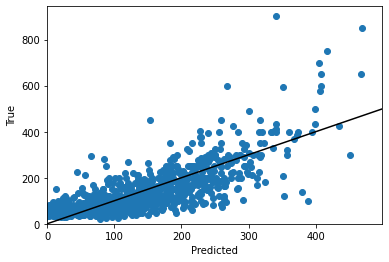

In [395]:
train_MSE, test_MSE, test_pred = run_OLS(train_y, test_y, train_vals, test_vals)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

## h) Further improvements?

In the above parts, we have seen the strength of adding more (useful) features in improving both training and test performance. In this part, we want to test the idea of whether we can further improve our model by not adding more features, but making wise use of the features.

First, we prepare a data-subsampled dataset with only 20% of the training and test data points retained. This saves time for us to test more settings.

In [396]:
data_sampling_ratio = 0.20
train_n_rows_to_sample = int(round(data_sampling_ratio * train_vals.shape[0]))
train_idx_rows_to_sample = rand.sample(list(range(len(train_vals))), train_n_rows_to_sample)

train_vals_real_small = train_vals_real[train_idx_rows_to_sample, :]
train_vals_from_string_small = train_vals_from_string[train_idx_rows_to_sample, :]
train_bv_small = train_bv[train_idx_rows_to_sample, :]
train_cat_vals_small = train_cat_vals[train_idx_rows_to_sample, :]
train_set_vals_small = train_set_vals[train_idx_rows_to_sample, :]
train_zip_small = train_zip[train_idx_rows_to_sample, :];
train_embed_small = train_embed[train_idx_rows_to_sample, :]

train_vals_small = np.concatenate((train_vals_real_small, 
                train_vals_from_string_small, 
                train_bv_small,
                train_cat_vals_small,
                train_set_vals_small, 
                train_zip_small,
                train_embed_small,
                np.ones(len(train_vals_real_small)).reshape([len(train_vals_real_small),1]) ), axis=1)

train_y_small = train_y.iloc[train_idx_rows_to_sample]

In [397]:
# Repeat with test set
data_sampling_ratio = 0.20
test_n_rows_to_sample = int(round(data_sampling_ratio * test_vals.shape[0]))
test_idx_rows_to_sample = rand.sample(list(range(len(test_vals))), test_n_rows_to_sample)

test_vals_real_small = test_vals_real[test_idx_rows_to_sample, :]
test_vals_from_string_small = test_vals_from_string[test_idx_rows_to_sample, :]
test_bv_small = test_bv[test_idx_rows_to_sample, :]
test_cat_vals_small = test_cat_vals[test_idx_rows_to_sample, :]
test_set_vals_small = test_set_vals[test_idx_rows_to_sample, :]
test_zip_small = test_zip[test_idx_rows_to_sample, :];
test_embed_small = test_embed[test_idx_rows_to_sample, :]

test_vals_small = np.concatenate((test_vals_real_small, 
                test_vals_from_string_small, 
                test_bv_small,
                test_cat_vals_small,
                test_set_vals_small, 
                test_zip_small,
                test_embed_small,
                np.ones(len(test_vals_real_small)).reshape([len(test_vals_real_small),1]) ), axis=1)

test_y_small = test_y.iloc[test_idx_rows_to_sample]

Then we train the linear regressor on the subsampled training set, and take a look at training and test MSEs. Despite the fact we shrunk our dataset, **this step may take a few minutes**.

Train MSE	 3.646020038004943e-11
Test MSE	 56790.215717319654


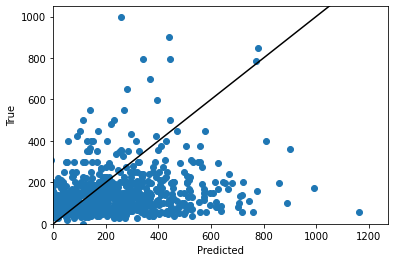

In [398]:
train_MSE_small, test_MSE_small, test_pred_small = run_OLS(train_y_small, test_y_small, train_vals_small, test_vals_small)

print("Train MSE\t", str(train_MSE_small))
print("Test MSE\t", str(test_MSE_small))

plot_pred_true(test_pred_small.flatten(), test_y_small)

**QUESTION H1)**: Compare the training and test MSEs on the data-subsampled dataset with those on the original dataset: the one that includes all data points and all features, as you did in the cell above the heading of this section. For these two fitted models, are they overfitting or underfitting? Which one over/underfits more? Why?

**YOUR RESPONSE:** 

They both overfit. The second one overfits more. This is because the training error in the second one is extremely low while the test error is extremely large. Compared with the second one, the training error is just about half of the testing error in the first one. Basically in the second one the training model just memorized the data.  

What we are going to try first is to randomly select only a subset of the **text embedding** features for model fitting and prediction. In the next cell, randomly sample 10% of the text embedding features **from the data-subsampled training and test datasets** (so that the following steps would not take too much time) and **retain all the other features (including the offest)**. We call this the entire data-subsampled dataset (i.e., not feature-subsampled) in the following context. Then, use the new set of features to fit a linear regression model on the training set and predict on the test set. Print the training and test MSEs.

In [399]:
import random
import math
subset_sampling_ratio = 0.1
selected_feature_idx = random.sample(range(0, train_embed_small.shape[1]-1), math.floor(train_embed_small.shape[1] * 0.1))
selected_train_vals_small = train_vals_small[:, selected_feature_idx]
selected_test_vals_small = test_vals_small[:, selected_feature_idx]

Train MSE	 6956.746024344038
Test MSE	 8713.641212967546


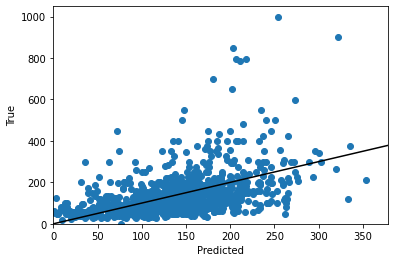

In [400]:
selected_train_MSE_small, selected_test_MSE_small, selected_test_pred_small = run_OLS(train_y_small, test_y_small, selected_train_vals_small, selected_test_vals_small)

print("Train MSE\t", str(selected_train_MSE_small))
print("Test MSE\t", str(selected_test_MSE_small))

plot_pred_true(selected_test_pred_small.flatten(), test_y_small)

In the next cell, test on a collection of the number of text embedding features to sample, and plot the change of train and test MSEs. This may take several minutes, but you would not need to do it multiple times as long as your code in the above cell works well. 

In [401]:
train_MSE_sub_all = []
test_MSE_sub_all = []

# the collection of number of text embedding features to sample
n_embed_to_sample_all = [10, 50, 100, 200, 500, 1000, 2000, 3000, 4000]

for n_embed_to_sample in n_embed_to_sample_all:
    print("Number of text embedding features to sample: ", str(n_embed_to_sample))
    idx_embed_to_sample = random.sample(range(0, train_embed.shape[1]-1), n_embed_to_sample)
    
    train_embed_sub = train_vals_small[:, idx_embed_to_sample]
    test_embed_sub = test_vals_small[:, idx_embed_to_sample]
    
    train_vals_sub = np.concatenate((train_vals_real_small, 
                train_vals_from_string_small, 
                train_bv_small,
                train_cat_vals_small,
                train_set_vals_small, 
                train_zip_small,
                train_embed_sub,
                np.ones(len(train_vals_real_small)).reshape([len(train_vals_real_small),1]) ), axis=1)
    
    test_vals_sub = np.concatenate((test_vals_real_small, 
                test_vals_from_string_small, 
                test_bv_small,
                test_cat_vals_small,
                test_set_vals_small, 
                test_zip_small,
                test_embed_sub,
                np.ones(len(test_vals_real_small)).reshape([len(test_vals_real_small),1]) ), axis=1)
    
    train_MSE, test_MSE, test_pred_sub = run_OLS(train_y_small, test_y_small, train_vals_sub, test_vals_sub)
    
    print("Train MSE\t", str(train_MSE))
    print("Test MSE\t", str(test_MSE))
    
    train_MSE_sub_all.append(train_MSE)
    test_MSE_sub_all.append(test_MSE)

Number of text embedding features to sample:  10
Train MSE	 3692.147838640274
Test MSE	 4692.740923143517
Number of text embedding features to sample:  50
Train MSE	 3638.3199234190133
Test MSE	 4666.229325520157
Number of text embedding features to sample:  100
Train MSE	 3596.417041808369
Test MSE	 4802.173094799994
Number of text embedding features to sample:  200
Train MSE	 3425.613736912246
Test MSE	 4673.252384825823
Number of text embedding features to sample:  500
Train MSE	 3112.1524568964314
Test MSE	 4799.855784215112
Number of text embedding features to sample:  1000
Train MSE	 2692.3074107139346
Test MSE	 5747.151032757539
Number of text embedding features to sample:  2000
Train MSE	 1824.1450202161411
Test MSE	 8445.563051531293
Number of text embedding features to sample:  3000
Train MSE	 955.6772704698365
Test MSE	 18779.937968360628
Number of text embedding features to sample:  4000
Train MSE	 133.40710338269665
Test MSE	 252268.4274192785


In the next cell, plot the change of train and test MSEs with the number of sampled features, together with two horizontal lines showing the train and test MSEs on the entire data-subsampled dataset (i.e., not feature-subsampled). 

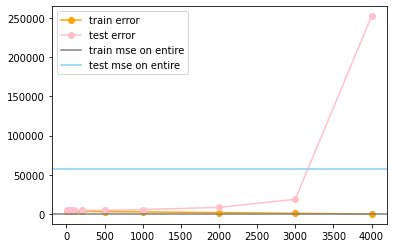

In [402]:
plt.plot(n_embed_to_sample_all, train_MSE_sub_all, linestyle='-', marker='o',label = 'train error', color = 'orange');
plt.plot(n_embed_to_sample_all, test_MSE_sub_all, linestyle='-', marker='o',label = 'test error', color = 'pink');
plt.axhline(train_MSE_small, linestyle='-', label = 'train mse on entire', color = 'grey');
plt.axhline(test_MSE_small, linestyle='-', label = 'test mse on entire', color = 'skyblue');
plt.legend()
plt.show()

**QUESTION H2)**: 
- In the plot you get above:does the model over/underfit worse when the number of sampled text embedding feature increases?  Why?
- Compared to the model performance on the entire data-subsampled dataset (i.e., not feature-subsampled), how does feature subsampling work, in terms of prediction error and generalization?

**YOUR RESPONSE:** 

The model overfit worse when the number of sampled text embedding features increases. Thhis is because as we added more features, some of them are not useful for the prediction of the test set. Therefore, even though these features works well for the training set, the model basically memorized the features in the training set, and this might not suitable for test set. 

The feature subsampling works better compared to the model performance on the entire data-subsampled dataset. Because the test error is lower, the prediction error and generalization are better. However, in the sample size of 4000, the subsampling works worse. But this is due to the randomness of our experiment.  

Finally, we explore a "smarter" way of reducing the number of features using Principal Component Analysis (PCA) to embed the features. PCA projects the data onto a subspace of maximal variance, preserving as much signal as possible in fewer dimensions. We'll cover PCA later in the course.

In the next cell, compute the Singular Value Decomposition (SVD) of the embedding features by using np.linalg.svd(). It may take a couple of trys to converge, so be aware that this cell **may take several minutes to run.**

In [403]:
u_train, s_train, vh_train = np.linalg.svd(train_embed_small)

In [404]:
u_test, s_test, vh_test = np.linalg.svd(test_embed_small)

In the next cell, test on a collection of the rank of the PCA to use, and plot the change of train and test MSEs. **This may take several minutes.** In particular, take the first $k$ columns of $V$ where $USV^T$ is the SVD of the embedding feature matrix and right multiply the embedding feature matrix with the first $k$ columns of $V$. 

In [405]:
train_MSE_pca_all = []
test_MSE_pca_all = []

print('Train MSE on the data-subsampled dataset \t', str(train_MSE_small))
print('Test MSE on the data-subsampled dataset \t', str(test_MSE_small))

k_all = [10, 50, 100, 500, 1000]

for k in k_all:
    print(k)
    
    V_k = vh_train[:, range(k)]
    
    train_embed_pca =  np.dot(train_embed_small,V_k) 
    test_embed_pca = np.dot(test_embed_small,V_k) 

    train_vals_pca = np.concatenate((train_vals_real_small, 
                train_vals_from_string_small, 
                train_bv_small,
                train_cat_vals_small,
                train_set_vals_small, 
                train_zip_small,
                train_embed_pca,
                np.ones(len(train_vals_real_small)).reshape([len(train_vals_real_small),1]) ), axis=1)
    
    test_vals_pca = np.concatenate((test_vals_real_small, 
                test_vals_from_string_small, 
                test_bv_small,
                test_cat_vals_small,
                test_set_vals_small, 
                test_zip_small,
                test_embed_pca,
                np.ones(len(test_vals_real_small)).reshape([len(test_vals_real_small),1]) ), axis=1)
    
    train_MSE, test_MSE, test_pred_sub = run_OLS(train_y_small, test_y_small, train_vals_pca, test_vals_pca)
    
    print("Train MSE\t", str(train_MSE))
    print("Test MSE\t", str(test_MSE))
    
    train_MSE_pca_all.append(train_MSE)
    test_MSE_pca_all.append(test_MSE)


Train MSE on the data-subsampled dataset 	 3.646020038004943e-11
Test MSE on the data-subsampled dataset 	 56790.215717319654
10
Train MSE	 3693.3033576304297
Test MSE	 4704.966734812622
50
Train MSE	 3624.227848592355
Test MSE	 4725.24450185509
100
Train MSE	 3562.9453332251305
Test MSE	 4703.653659932119
500
Train MSE	 3139.7426018224446
Test MSE	 4941.587385002612
1000
Train MSE	 2681.2960118930305
Test MSE	 5672.459347994128


In the next cell, plot the change of train and test MSEs in the PCA case, in the same way as random sampling.

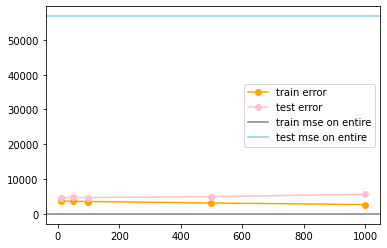

In [406]:
plt.plot(k_all, train_MSE_pca_all, linestyle='-', marker='o',label = 'train error', color = 'orange');
plt.plot(k_all, test_MSE_pca_all, linestyle='-', marker='o',label = 'test error', color = 'pink');
plt.axhline(train_MSE_small, linestyle='-', label = 'train mse on entire', color = 'grey');
plt.axhline(test_MSE_small, linestyle='-', label = 'test mse on entire', color = 'skyblue');
plt.legend()
plt.show()

**QUESTION H3)**: 
- In the PCA plot you get above, does the model over/underfits worse when the number of sampled text embedding feature increases? 
- Compared to randomly sampling the text embedding features, how does PCA works, in terms of prediction error and generalization?

**YOUR RESPONSE:** 

The model overfits worse when the number of sampled text embedding feature increases.

Compared to randomly sampling the text embedding features, the PCA works better in therms of prediction error and generalization. This is because v_k selected the maximal variance but the random sampling only selected k random features which might be trivial to our test set. 